# Import Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import seaborn as sns
import numpy as np 
import xgboost as xgb
import joblib
import re
import os
from math import sqrt
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi
from datetime import datetime, timedelta
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split, GridSearchCV

# Visualization Style

In [2]:
formatter = ticker.StrMethodFormatter('Rp.{x:,.0f}')
sns.set_theme(style='darkgrid')
sns.set_palette("deep")
mpl.rcParams['font.family'] = 'sans'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

# Data Collecting

In [3]:
import sys
sys.path.append('..')

from scripts import get_data_from_mongo

In [4]:
df_import = get_data_from_mongo.get_data_mongo('tanah_bali_clean')
df_import = pd.DataFrame(df_import)

----------------------------------------------
Connected to db db_tanah_bali
Total documents get: 23548
Dissconnected!


In [5]:
df = df_import.copy()
df.head()

,_id,date,land_area,price_total,price_per_m2,subdistrict,regency,log_land_area,log_price_total,log_price_per_m2,land_area_cat
0,666df5ab85e1880f30359ede,2024-05-19,200.0,7.000000e+08,3500000.0,Ubud,Gianyar,5.298317,20.366591,15.068274,small
1,666df5ab85e1880f30359edf,2024-05-19,200.0,8.000000e+08,4000000.0,Kuta Selatan,Badung,5.298317,20.500122,15.201805,small
2,666df5ab85e1880f30359ee0,2024-05-19,376.0,3.572000e+09,9500000.0,Kuta Selatan,Badung,5.929589,21.996391,16.066802,small
3,666df5ab85e1880f30359ee1,2024-05-19,100.0,1.500000e+09,15000000.0,Kuta,Badung,4.605170,21.128731,16.523561,small
4,666df5ab85e1880f30359ee2,2024-05-19,2400.0,6.000000e+10,25000000.0,Kuta,Badung,7.783224,24.817610,17.034386,medium


# Data Preparation

### Check Dataframe

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23548 entries, 0 to 23547
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   _id               23548 non-null  object        
 1   date              23548 non-null  datetime64[ns]
 2   land_area         23548 non-null  float64       
 3   price_total       23548 non-null  float64       
 4   price_per_m2      23548 non-null  float64       
 5   subdistrict       23548 non-null  object        
 6   regency           23548 non-null  object        
 7   log_land_area     23548 non-null  float64       
 8   log_price_total   23548 non-null  float64       
 9   log_price_per_m2  23548 non-null  float64       
 10  land_area_cat     23548 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 2.0+ MB


### Delete Unnecessary Column

In [7]:
df = df.drop(columns='_id', axis=1)
df.head()

,date,land_area,price_total,price_per_m2,subdistrict,regency,log_land_area,log_price_total,log_price_per_m2,land_area_cat
0,2024-05-19,200.0,7.000000e+08,3500000.0,Ubud,Gianyar,5.298317,20.366591,15.068274,small
1,2024-05-19,200.0,8.000000e+08,4000000.0,Kuta Selatan,Badung,5.298317,20.500122,15.201805,small
2,2024-05-19,376.0,3.572000e+09,9500000.0,Kuta Selatan,Badung,5.929589,21.996391,16.066802,small
3,2024-05-19,100.0,1.500000e+09,15000000.0,Kuta,Badung,4.605170,21.128731,16.523561,small
4,2024-05-19,2400.0,6.000000e+10,25000000.0,Kuta,Badung,7.783224,24.817610,17.034386,medium


### Change Datatype of Date Column

In [8]:
df['date'] = pd.to_datetime(df['date'])

# EDA (Exploratory Data Analysis)

### Show All Subdistrict in Regency

In [9]:
df['regency'].unique()

array(['Gianyar', 'Badung', 'Tabanan', 'Denpasar', 'Buleleng',
       'Klungkung', 'Jembrana', 'Karangasem', 'Bangli', 'Baudng'],
      dtype=object)

In [10]:
pd.set_option('display.max_rows', None)

- Badung

In [11]:
subd = df[df['regency'] == 'Badung']['subdistrict'].unique()
subd = pd.DataFrame(subd, columns=['subdistrict'])
subd

,subdistrict
0,Kuta Selatan
1,Kuta
2,Kuta Utara
3,Mengwi
4,Abiansemal
5,Petang
6,Klungkung


- Bangli

In [12]:
subd = df[df['regency'] == 'Bangli']['subdistrict'].unique()
subd = pd.DataFrame(subd, columns=['subdistrict'])
subd

,subdistrict
0,Kintamani
1,Bangli


- Buleleng

In [13]:
subd = df[df['regency'] == 'Buleleng']['subdistrict'].unique()
subd = pd.DataFrame(subd, columns=['subdistrict'])
subd

,subdistrict
0,Banjar
1,Buleleng
2,Kubu Tambahan
3,Sukasada
4,Gerokgak
5,Sawan
6,Tejakula
7,Busung Biu
8,Busungbiu
9,Seririt


- Denpasar

In [14]:
subd = df[df['regency'] == 'Denpasar']['subdistrict'].unique()
subd = pd.DataFrame(subd, columns=['subdistrict'])
subd

,subdistrict
0,Denpasar Timur
1,Denpasar Barat
2,Denpasar Utara
3,Denpasar Selatan


- Gianyar

In [15]:
subd = df[df['regency'] == 'Gianyar']['subdistrict'].unique()
subd = pd.DataFrame(subd, columns=['subdistrict'])
subd

,subdistrict
0,Ubud
1,Sukawati
2,Tampaksiring
3,Gianyar
4,Tegallalang
5,Blahbatuh
6,Payangan


- Jembrana

In [16]:
subd = df[df['regency'] == 'Jembrana']['subdistrict'].unique()
subd = pd.DataFrame(subd, columns=['subdistrict'])
subd

,subdistrict
0,Pekutatan
1,Jembrana
2,Negara
3,Mendoyo
4,Melaya


- Karangasem

In [17]:
subd = df[df['regency'] == 'Karangasem']['subdistrict'].unique()
subd = pd.DataFrame(subd, columns=['subdistrict'])
subd

,subdistrict
0,Manggis
1,Karangasem
2,Kubu
3,Selat
4,Abang
5,Sidemen
6,Bebandem
7,Rendang


- Klungkung

In [18]:
subd = df[df['regency'] == 'Klungkung']['subdistrict'].unique()
subd = pd.DataFrame(subd, columns=['subdistrict'])
subd

,subdistrict
0,Nusa Penida
1,Banjarangkan
2,Klungkung
3,Dawan


- Tabanan

In [19]:
subd = df[df['regency'] == 'Tabanan']['subdistrict'].unique()
subd = pd.DataFrame(subd, columns=['subdistrict'])
subd

,subdistrict
0,Lalanglinggah
1,Kerambitan
2,Kediri
3,Selemadeg
4,Selemadeg Timur
5,Tabanan
6,Penebel
7,Selemadeg Barat
8,Marga
9,Pupuan


- Reset the display settings

In [20]:
pd.reset_option('display.max_rows')

### Summary Numerical Statistics

In [21]:
df.describe()

,date,land_area,price_total,price_per_m2,log_land_area,log_price_total,log_price_per_m2
count,23548,23548.000000,2.354800e+04,2.354800e+04,23548.000000,23548.000000,23548.000000
mean,2024-02-29 15:09:37.883472128,3362.841430,2.225392e+10,8.657987e+06,7.015791,22.676352,15.660561
min,2022-12-11 00:00:00,18.000000,1.100000e+08,5.517241e+05,2.890372,18.515991,13.220803
25%,2024-01-20 00:00:00,400.000000,2.515188e+09,3.742857e+06,5.991465,21.645613,15.135360
50%,2024-02-19 00:00:00,990.000000,6.669000e+09,6.500000e+06,6.897705,22.620736,15.687313
75%,2024-04-19 00:00:00,2800.000000,1.795200e+10,1.200000e+07,7.937375,23.610967,16.300417
max,2024-05-19 00:00:00,77000.000000,5.379000e+11,7.500000e+07,11.251561,27.010939,18.132999
std,NaN,7470.969926,5.257399e+10,7.040449e+06,1.392966,1.465196,0.827702


### Summary Categorical Statistics

In [22]:
df.describe(include=object)

,subdistrict,regency,land_area_cat
count,23548,23548,23548
unique,58,10,3
top,Kuta Selatan,Badung,medium
freq,6268,12599,11545


### Land Area Analysis

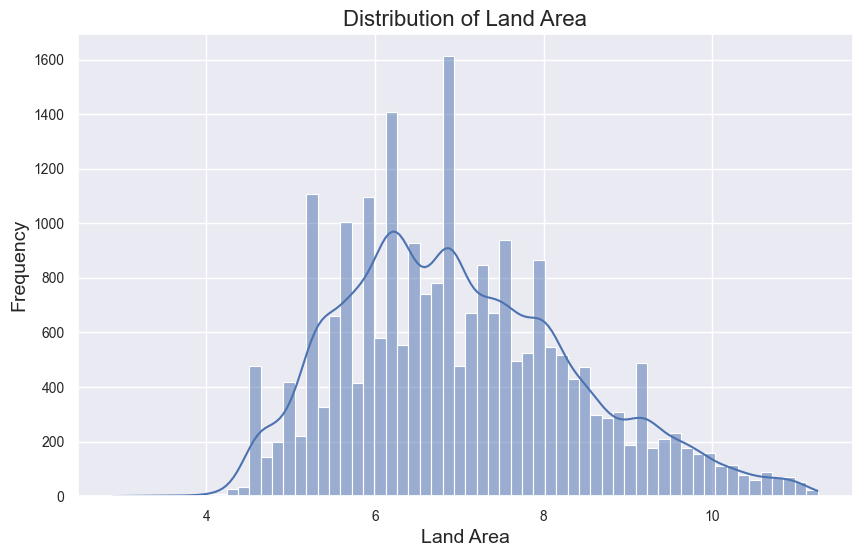

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(df['log_land_area'], kde=True)
plt.title('Distribution of Land Area')
plt.xlabel('Land Area')
plt.ylabel('Frequency')
plt.show()

### Total Price Distribution

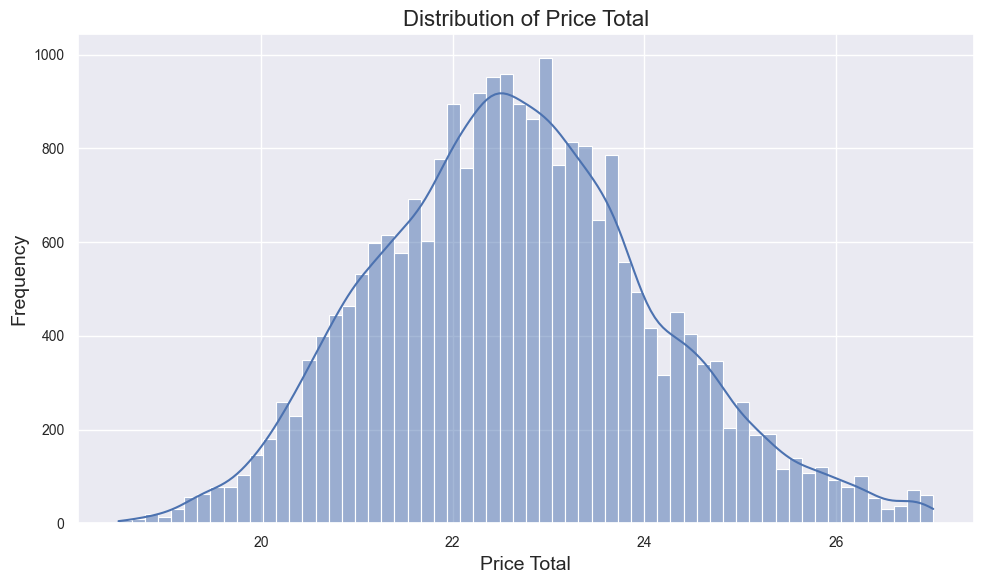

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(df['log_price_total'], kde=True)
plt.title('Distribution of Price Total')
plt.xlabel('Price Total')
plt.ylabel('Frequency')
# plt.gca().xaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

### Price per m2 Distribution

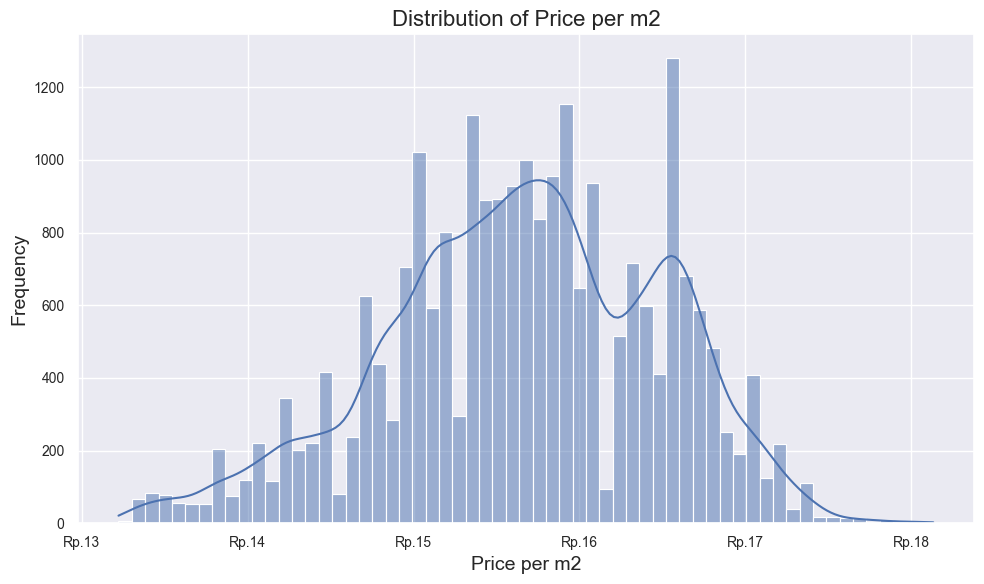

In [25]:
plt.figure(figsize=(10, 6))
sns.histplot(df['log_price_per_m2'], kde=True)
plt.title('Distribution of Price per m2')
plt.xlabel('Price per m2')
plt.ylabel('Frequency')
plt.gca().xaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

### Subdistrict Regency

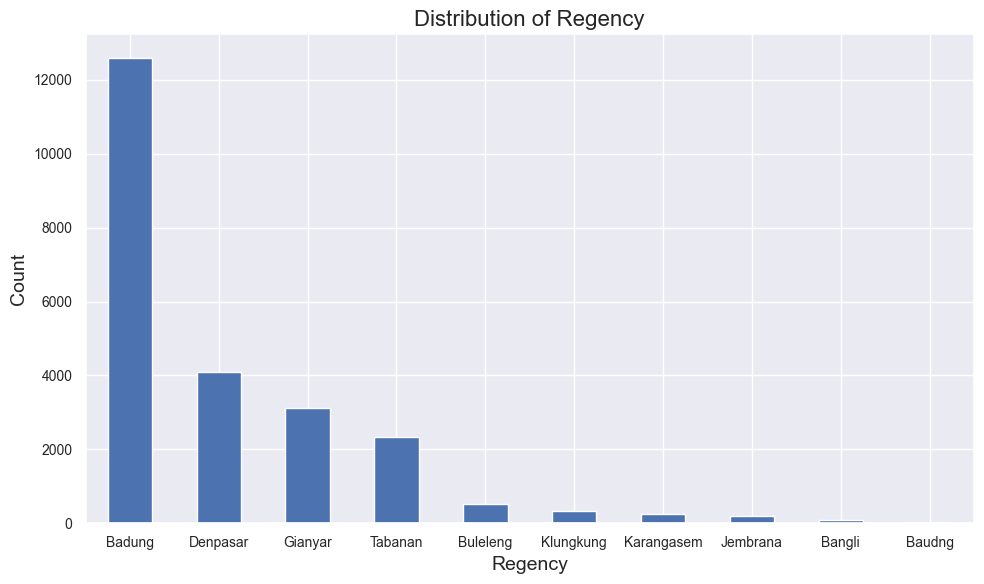

In [26]:
plt.figure(figsize=(10, 6))
df['regency'].value_counts().sort_values(ascending=False).plot(kind='bar')
plt.title('Distribution of Regency')
plt.xlabel('Regency')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [27]:
df['regency'].value_counts().to_frame().T

regency,Badung,Denpasar,Gianyar,Tabanan,Buleleng,Klungkung,Karangasem,Jembrana,Bangli,Baudng
count,12599,4091,3123,2327,522,335,256,185,98,12


### Land Area Category Distribution

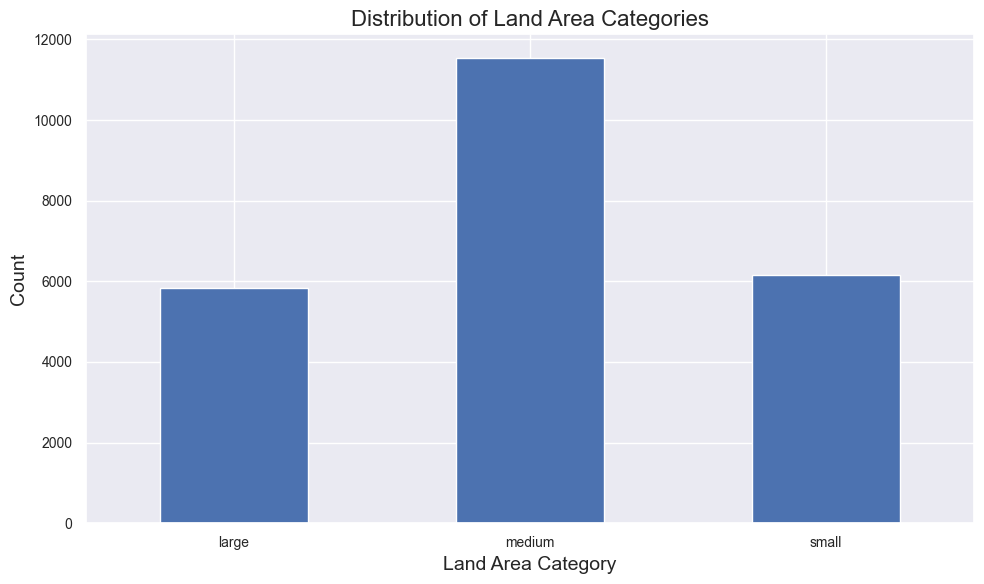

In [28]:
plt.figure(figsize=(10, 6))
df['land_area_cat'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Land Area Categories')
plt.xlabel('Land Area Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [29]:
df['land_area_cat'].value_counts().to_frame().T

land_area_cat,medium,small,large
count,11545,6158,5845


### Showing Price Total Over Time

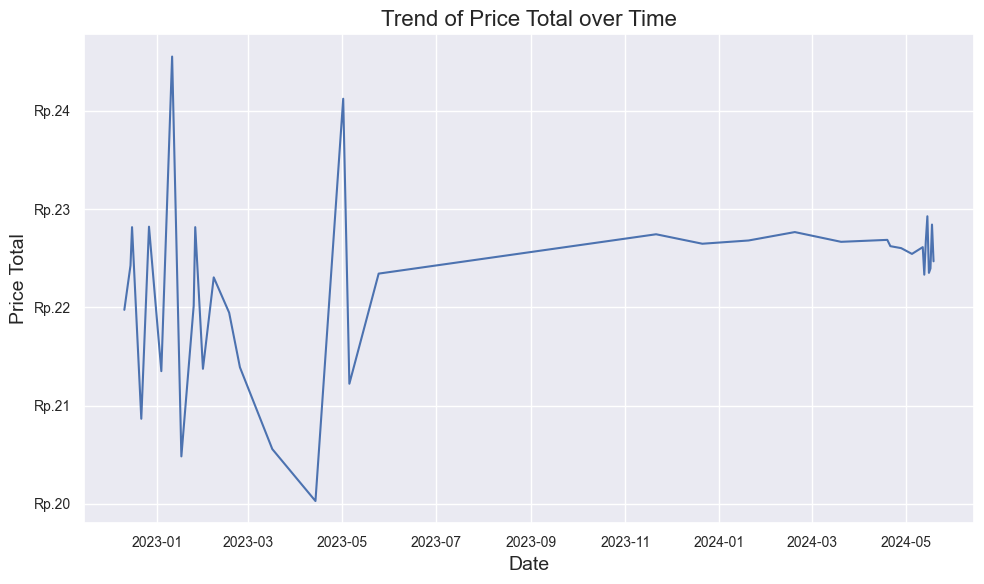

In [30]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='log_price_total', data=df, errorbar=None)
plt.title('Trend of Price Total over Time')
plt.xlabel('Date')
plt.ylabel('Price Total')
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

### Showing Price per m2 Over Time

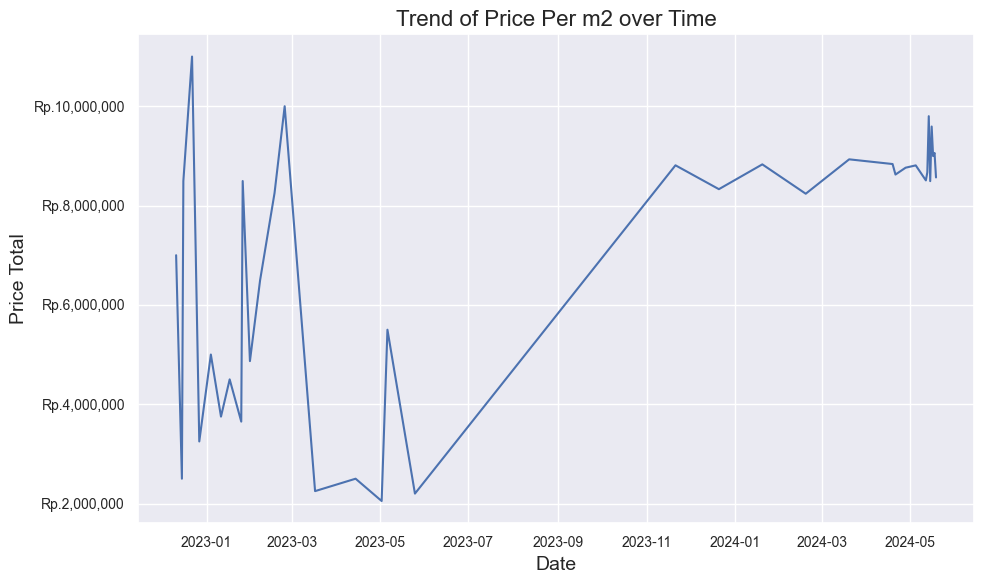

In [31]:
plt.figure(figsize=(10, 6))
sns.lineplot(x='date', y='price_per_m2', data=df, errorbar=None)
plt.title('Trend of Price Per m2 over Time')
plt.xlabel('Date')
plt.ylabel('Price Total')
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

### Showing Relationship between Price Total and Regency  

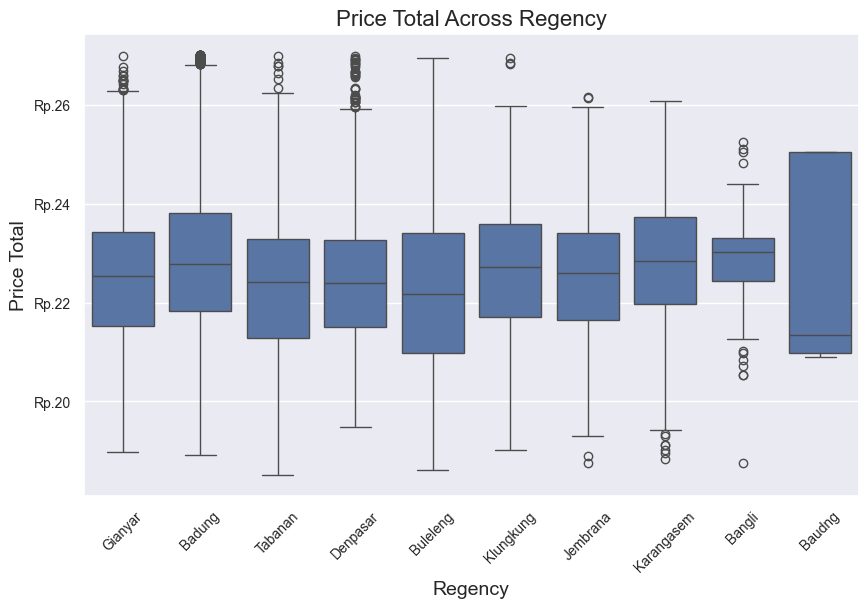

In [32]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='regency', y='log_price_total', data=df)
plt.title('Price Total Across Regency')
plt.xlabel('Regency')
plt.ylabel('Price Total')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

In [33]:
price_sum_by_regency = df.groupby('regency')['log_price_total'].sum()
price_sum_by_regency = price_sum_by_regency.sort_values(ascending=False)
price_sum_by_regency

regency
Badung        288187.669783
Denpasar       91863.219927
Gianyar        70418.205050
Tabanan        51903.315168
Buleleng       11534.086460
Klungkung       7582.094314
Karangasem      5824.502374
Jembrana        4163.463536
Bangli          2237.048386
Baudng           269.124430
Name: log_price_total, dtype: float64

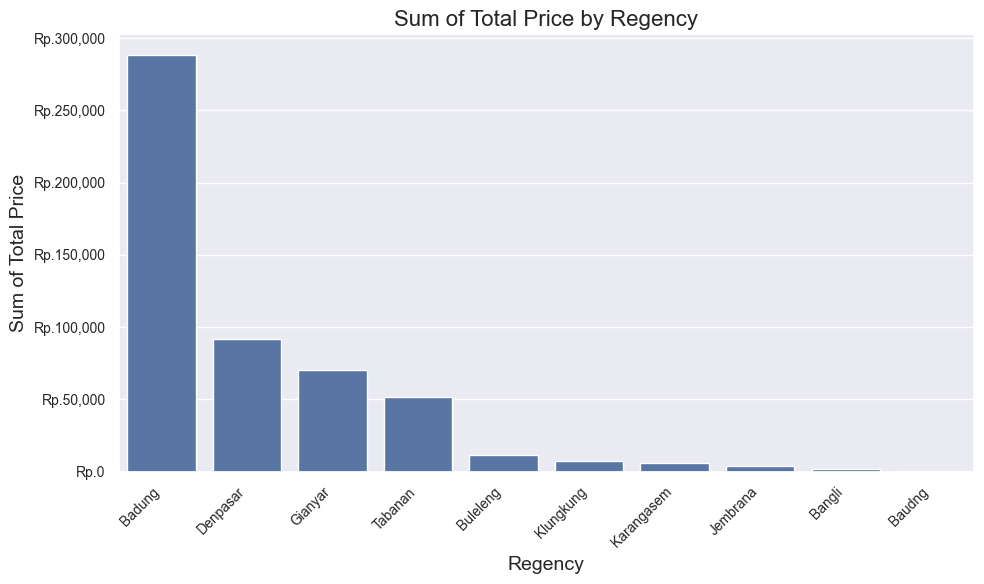

In [34]:
plt.figure(figsize=(10, 6))
sns.barplot(x=price_sum_by_regency.index, y=price_sum_by_regency.values)
plt.title('Sum of Total Price by Regency')
plt.xlabel('Regency')
plt.ylabel('Sum of Total Price')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

In [35]:
price_mean_by_regency = df.groupby('regency')['price_total'].mean()
price_mean_by_regency = price_mean_by_regency.sort_values(ascending=False)
price_mean_by_regency

regency
Badung        2.817985e+10
Baudng        2.600933e+10
Klungkung     1.986459e+10
Karangasem    1.771496e+10
Gianyar       1.757699e+10
Jembrana      1.743830e+10
Denpasar      1.467764e+10
Tabanan       1.380939e+10
Bangli        1.332145e+10
Buleleng      1.128426e+10
Name: price_total, dtype: float64

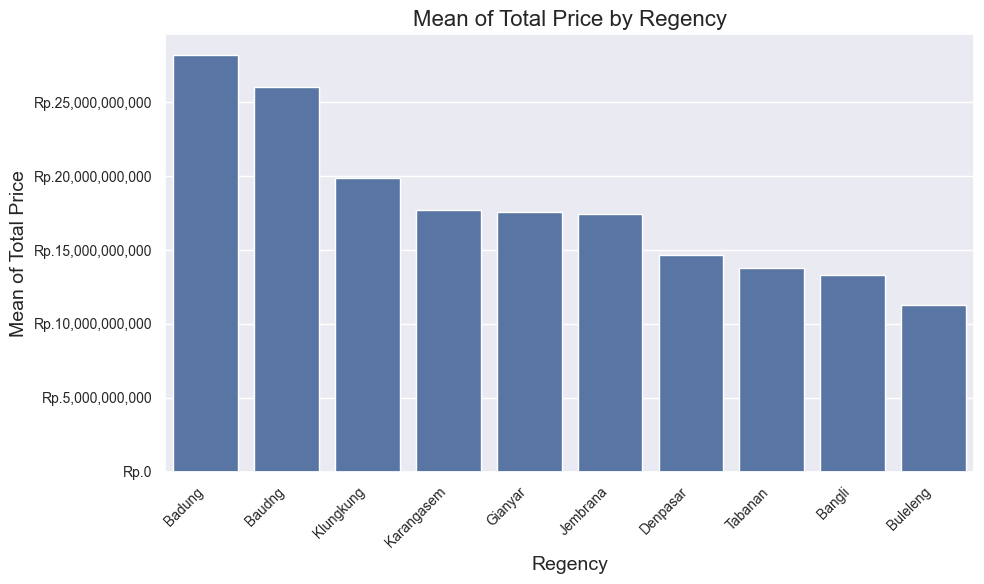

In [36]:
plt.figure(figsize=(10, 6))
sns.barplot(x=price_mean_by_regency.index, y=price_mean_by_regency.values)
plt.title('Mean of Total Price by Regency')
plt.xlabel('Regency')
plt.ylabel('Mean of Total Price')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

### Showing Relationship between Price per m2 and Regency  

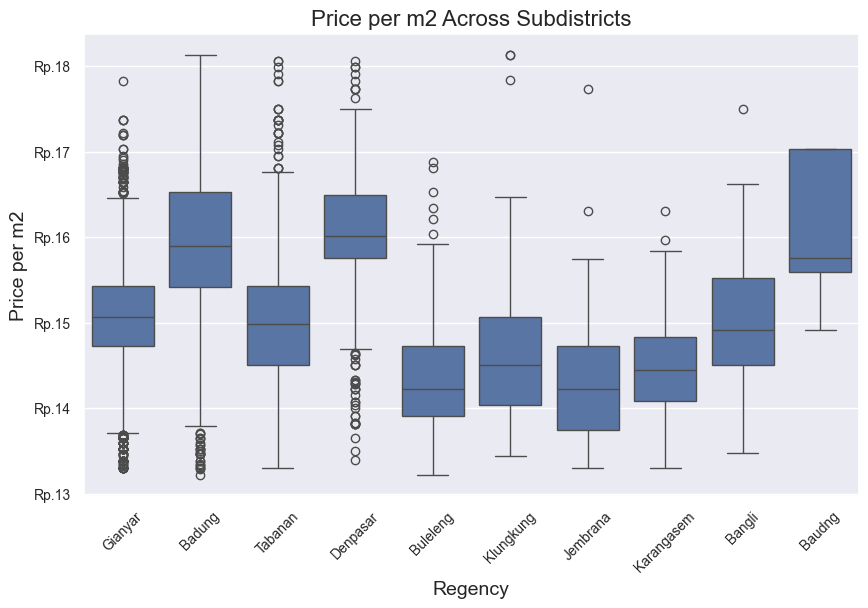

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='regency', y='log_price_per_m2', data=df)
plt.title('Price per m2 Across Subdistricts')
plt.xlabel('Regency')
plt.ylabel('Price per m2')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

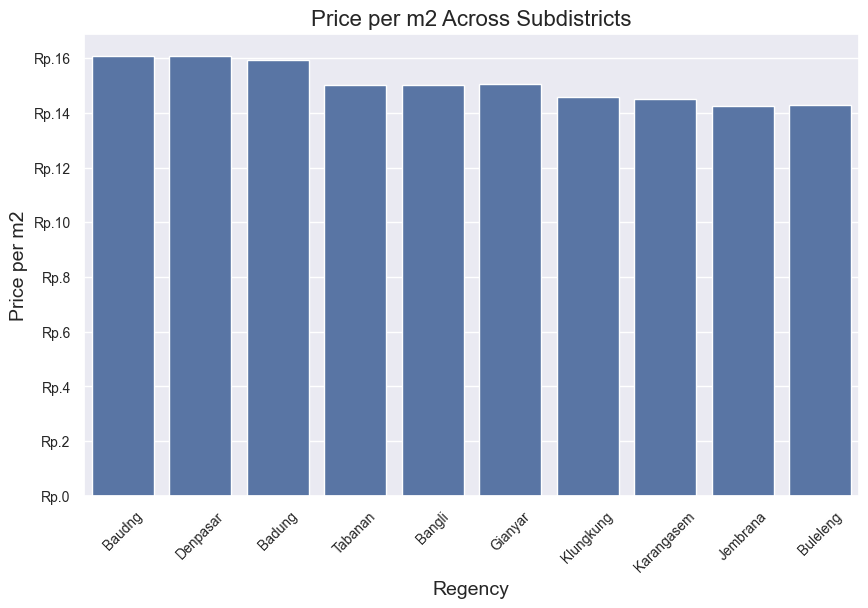

In [38]:
plt.figure(figsize=(10, 6))
sns.barplot(x='regency', y='log_price_per_m2', data=df, order=df.groupby('regency')['price_per_m2'].mean().sort_values(ascending=False).index, errorbar=None)
plt.title('Price per m2 Across Subdistricts')
plt.xlabel('Regency')
plt.ylabel('Price per m2')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(formatter)
plt.show()

In [39]:
pricem2_sum_by_regency = df.groupby('regency')['price_per_m2'].sum()
pricem2_sum_by_regency = pricem2_sum_by_regency.sort_values(ascending=False)
pricem2_sum_by_regency

regency
Badung        1.313127e+11
Denpasar      4.540337e+10
Gianyar       1.317797e+10
Tabanan       1.029229e+10
Klungkung     1.079135e+09
Buleleng      1.051856e+09
Karangasem    5.892445e+08
Bangli        4.286496e+08
Jembrana      3.937970e+08
Baudng        1.492698e+08
Name: price_per_m2, dtype: float64

In [40]:
pricem2_mean_by_regency = df.groupby('regency')['price_per_m2'].mean()
pricem2_mean_by_regency = pricem2_mean_by_regency.sort_values(ascending=False)
pricem2_mean_by_regency

regency
Baudng        1.243915e+07
Denpasar      1.109836e+07
Badung        1.042247e+07
Tabanan       4.422987e+06
Bangli        4.373976e+06
Gianyar       4.219650e+06
Klungkung     3.221300e+06
Karangasem    2.301736e+06
Jembrana      2.128633e+06
Buleleng      2.015050e+06
Name: price_per_m2, dtype: float64

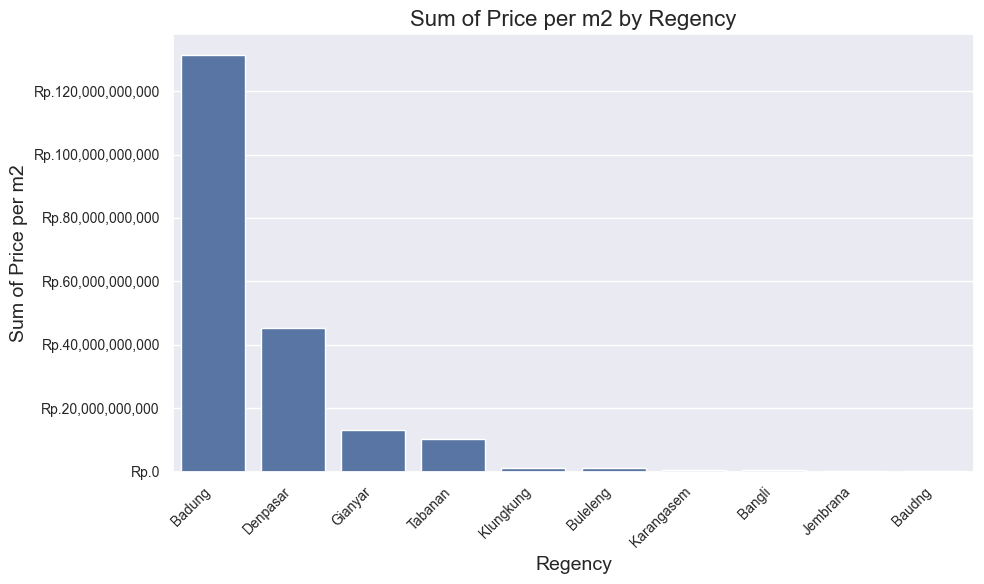

In [41]:
plt.figure(figsize=(10, 6))
sns.barplot(x=pricem2_sum_by_regency.index, y=pricem2_sum_by_regency.values)
plt.title('Sum of Price per m2 by Regency')
plt.xlabel('Regency')
plt.ylabel('Sum of Price per m2')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

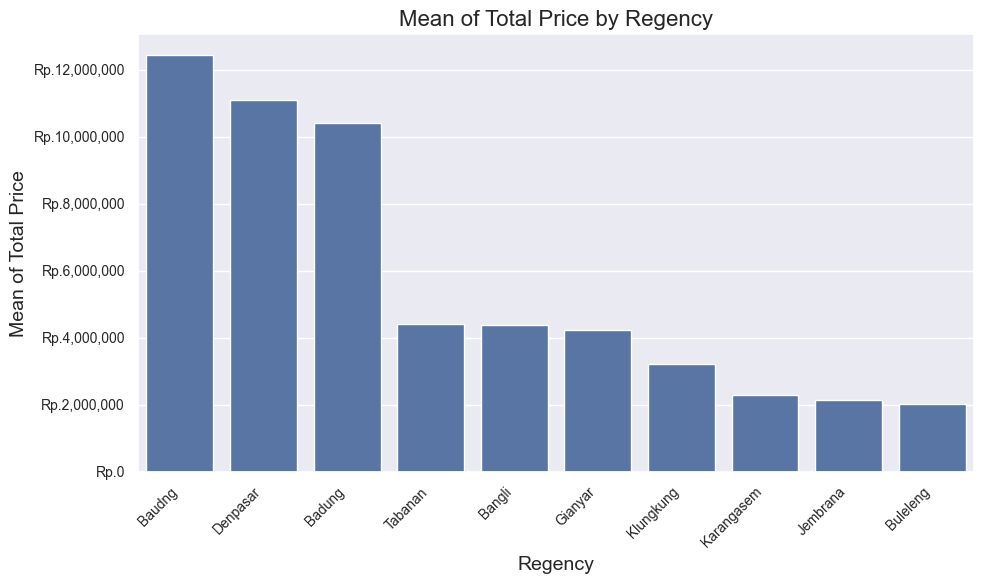

In [42]:
plt.figure(figsize=(10, 6))
sns.barplot(x=pricem2_mean_by_regency.index, y=pricem2_mean_by_regency.values)
plt.title('Mean of Total Price by Regency')
plt.xlabel('Regency')
plt.ylabel('Mean of Total Price')
plt.xticks(rotation=45, ha='right')
plt.gca().yaxis.set_major_formatter(formatter)
plt.tight_layout()
plt.show()

### Showing Relationship between Land Area and Price Total

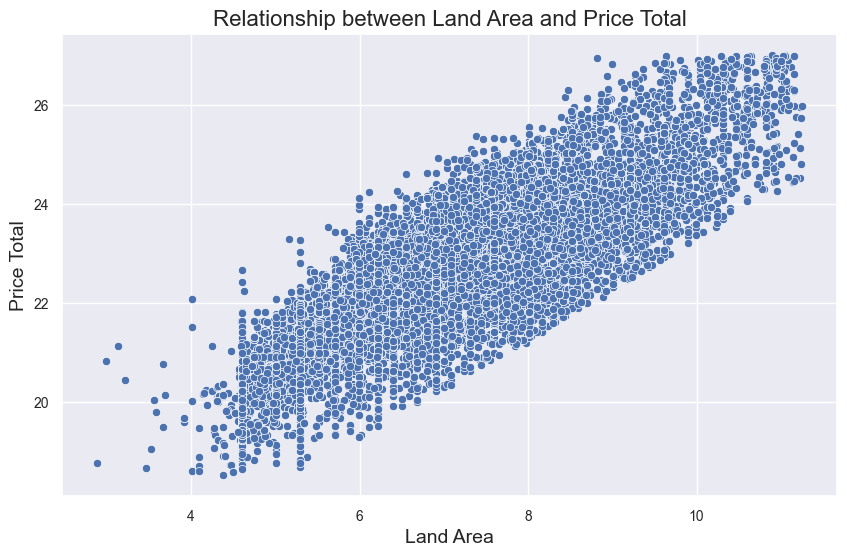

In [43]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='log_land_area', y='log_price_total', data=df)
plt.title('Relationship between Land Area and Price Total')
plt.xlabel('Land Area')
plt.ylabel('Price Total')
plt.show()

### Correlation Analysis

- Sort Price Total Value by Regency

In [44]:
price_sum_by_regency = df.groupby('regency')['log_price_total'].sum()
price_sum_by_regency.sort_values(ascending=False)

regency
Badung        288187.669783
Denpasar       91863.219927
Gianyar        70418.205050
Tabanan        51903.315168
Buleleng       11534.086460
Klungkung       7582.094314
Karangasem      5824.502374
Jembrana        4163.463536
Bangli          2237.048386
Baudng           269.124430
Name: log_price_total, dtype: float64

- Label Encoding on Regency Column

In [45]:
sorted_regencies = price_sum_by_regency.sort_values(ascending=True).index
encoding_dict = {regency: rank for rank, regency in enumerate(sorted_regencies, start=1)}

In [46]:
df['regency_encoded'] = df['regency'].map(encoding_dict)
df.head()

,date,land_area,price_total,price_per_m2,subdistrict,regency,log_land_area,log_price_total,log_price_per_m2,land_area_cat,regency_encoded
0,2024-05-19,200.0,7.000000e+08,3500000.0,Ubud,Gianyar,5.298317,20.366591,15.068274,small,8
1,2024-05-19,200.0,8.000000e+08,4000000.0,Kuta Selatan,Badung,5.298317,20.500122,15.201805,small,10
2,2024-05-19,376.0,3.572000e+09,9500000.0,Kuta Selatan,Badung,5.929589,21.996391,16.066802,small,10
3,2024-05-19,100.0,1.500000e+09,15000000.0,Kuta,Badung,4.605170,21.128731,16.523561,small,10
4,2024-05-19,2400.0,6.000000e+10,25000000.0,Kuta,Badung,7.783224,24.817610,17.034386,medium,10


- Sort Subdistrict Column by Sum of Price Total

In [47]:
price_sum_by_subd = df.groupby('subdistrict')['log_price_total'].sum()
price_sum_by_subd.sort_values(ascending=False)

subdistrict
Kuta Selatan        142579.548375
Kuta Utara           71603.985152
Denpasar Selatan     48305.697216
Kuta                 38758.220763
Ubud                 31651.404870
Mengwi               30940.528799
Kediri               26377.977699
Denpasar Barat       20932.570919
Kerambitan           12382.884949
Denpasar Utara       12141.085245
Sukawati             11781.543231
Denpasar Timur       10483.866547
Blahbatuh             9153.685237
Gianyar               7717.547112
Nusa Penida           5705.755020
Selemadeg             5538.481642
Tegallalang           4739.212313
Buleleng              4295.680407
Abiansemal            3400.436869
Payangan              3180.941487
Tabanan               2727.766996
Tampaksiring          2193.870800
Kintamani             2193.299269
Pekutatan             2128.699642
Karangasem            1594.975589
Selemadeg Timur       1560.333455
Banjar                1504.609035
Sukasada              1472.349500
Penebel               1468.079679
Te

- Label Encoding on Subdistrict Column

In [48]:
sorted_subd = price_sum_by_subd.sort_values(ascending=True).index
encoding_subd = {regency: rank for rank, regency in enumerate(sorted_subd, start=1)}

In [49]:
df['subdistrict_encoded'] = df['subdistrict'].map(encoding_subd)
df.head()

,date,land_area,price_total,price_per_m2,subdistrict,regency,log_land_area,log_price_total,log_price_per_m2,land_area_cat,regency_encoded,subdistrict_encoded
0,2024-05-19,200.0,7.000000e+08,3500000.0,Ubud,Gianyar,5.298317,20.366591,15.068274,small,8,54
1,2024-05-19,200.0,8.000000e+08,4000000.0,Kuta Selatan,Badung,5.298317,20.500122,15.201805,small,10,58
2,2024-05-19,376.0,3.572000e+09,9500000.0,Kuta Selatan,Badung,5.929589,21.996391,16.066802,small,10,58
3,2024-05-19,100.0,1.500000e+09,15000000.0,Kuta,Badung,4.605170,21.128731,16.523561,small,10,55
4,2024-05-19,2400.0,6.000000e+10,25000000.0,Kuta,Badung,7.783224,24.817610,17.034386,medium,10,55


- Sort Land Area Category by Sum of Price Total

In [50]:
price_sum_by_landcat = df.groupby('land_area_cat')['log_price_total'].sum()
price_sum_by_landcat.sort_values(ascending=False)

land_area_cat
medium    262100.931563
large     141719.935506
small     130161.862359
Name: log_price_total, dtype: float64

- Label Encoding on Land Area Category Column

In [51]:
sorted_land_area = price_sum_by_landcat.sort_values(ascending=True).index
encoding_land_area = {landcat: rank for rank, landcat in enumerate(sorted_land_area, start=1)}

In [52]:
df['land_area_cat_encoded'] = df['land_area_cat'].map(encoding_land_area)
df.head()

,date,land_area,price_total,price_per_m2,subdistrict,regency,log_land_area,log_price_total,log_price_per_m2,land_area_cat,regency_encoded,subdistrict_encoded,land_area_cat_encoded
0,2024-05-19,200.0,7.000000e+08,3500000.0,Ubud,Gianyar,5.298317,20.366591,15.068274,small,8,54,1
1,2024-05-19,200.0,8.000000e+08,4000000.0,Kuta Selatan,Badung,5.298317,20.500122,15.201805,small,10,58,1
2,2024-05-19,376.0,3.572000e+09,9500000.0,Kuta Selatan,Badung,5.929589,21.996391,16.066802,small,10,58,1
3,2024-05-19,100.0,1.500000e+09,15000000.0,Kuta,Badung,4.605170,21.128731,16.523561,small,10,55,1
4,2024-05-19,2400.0,6.000000e+10,25000000.0,Kuta,Badung,7.783224,24.817610,17.034386,medium,10,55,3


- Backup Dataframe

In [53]:
df_encoded = df.copy()
df_encoded.head()

,date,land_area,price_total,price_per_m2,subdistrict,regency,log_land_area,log_price_total,log_price_per_m2,land_area_cat,regency_encoded,subdistrict_encoded,land_area_cat_encoded
0,2024-05-19,200.0,7.000000e+08,3500000.0,Ubud,Gianyar,5.298317,20.366591,15.068274,small,8,54,1
1,2024-05-19,200.0,8.000000e+08,4000000.0,Kuta Selatan,Badung,5.298317,20.500122,15.201805,small,10,58,1
2,2024-05-19,376.0,3.572000e+09,9500000.0,Kuta Selatan,Badung,5.929589,21.996391,16.066802,small,10,58,1
3,2024-05-19,100.0,1.500000e+09,15000000.0,Kuta,Badung,4.605170,21.128731,16.523561,small,10,55,1
4,2024-05-19,2400.0,6.000000e+10,25000000.0,Kuta,Badung,7.783224,24.817610,17.034386,medium,10,55,3


- Delete the Categorical Column

In [54]:
df = df_encoded.copy()

df = df.drop(columns=['regency', 'subdistrict', 'land_area_cat'])
df.head()

,date,land_area,price_total,price_per_m2,log_land_area,log_price_total,log_price_per_m2,regency_encoded,subdistrict_encoded,land_area_cat_encoded
0,2024-05-19,200.0,7.000000e+08,3500000.0,5.298317,20.366591,15.068274,8,54,1
1,2024-05-19,200.0,8.000000e+08,4000000.0,5.298317,20.500122,15.201805,10,58,1
2,2024-05-19,376.0,3.572000e+09,9500000.0,5.929589,21.996391,16.066802,10,58,1
3,2024-05-19,100.0,1.500000e+09,15000000.0,4.605170,21.128731,16.523561,10,55,1
4,2024-05-19,2400.0,6.000000e+10,25000000.0,7.783224,24.817610,17.034386,10,55,3


- Correlation Matrix of Dataframe

In [55]:
if 'date' in df.columns:
    # Ensure the Date column is of datetime type
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    # Extract year, month, and day from the Date column
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    # Drop the Date column as it's now redundant
    df.drop('date', axis=1, inplace=True)

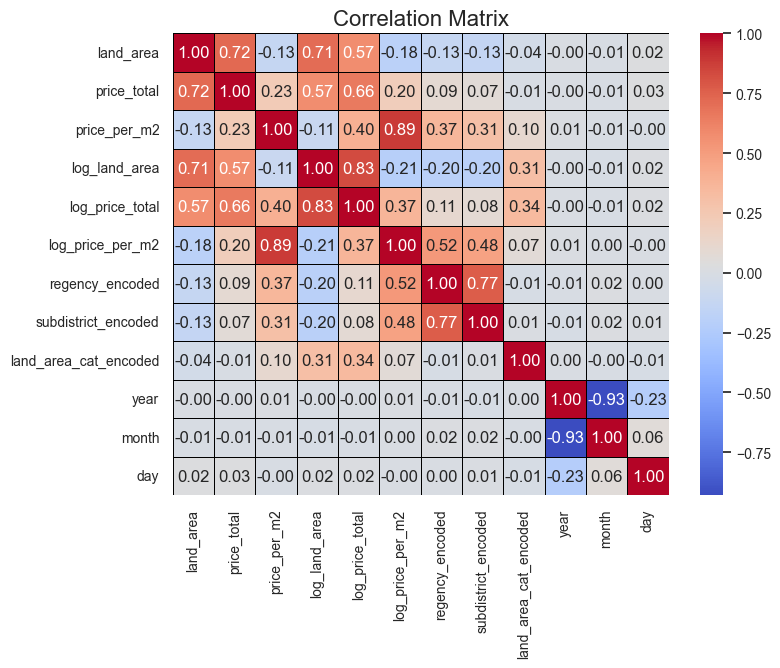

In [56]:
correlation_mat = df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_mat, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, linecolor='black')
plt.title("Correlation Matrix")
plt.show()

In [57]:
target_corr = correlation_mat['log_price_per_m2'].drop('log_price_per_m2')
print("Correlation with 'Price per m2':")
print(target_corr)

Correlation with 'Price per m2':
land_area               -0.184757
price_total              0.203357
price_per_m2             0.885937
log_land_area           -0.207572
log_price_total          0.367569
regency_encoded          0.520265
subdistrict_encoded      0.478453
land_area_cat_encoded    0.072183
year                     0.005488
month                    0.003017
day                     -0.001305
Name: log_price_per_m2, dtype: float64


In [61]:
correlation_threshold = 0.3
selected_features = target_corr[target_corr.abs() > correlation_threshold].index.tolist()

print("Selected features based on correlation:")
print(selected_features)

Selected features based on correlation:
['price_per_m2', 'log_price_total', 'regency_encoded', 'subdistrict_encoded']


# Model Building

### Select Features

In [62]:
features = ['year', 'month', 'day', 'regency_encoded', 'subdistrict_encoded']
# if 'Year' in df_copy.columns and 'Month' in df_copy.columns and 'Day' in df_copy.columns:
#     features.extend(['Year', 'Month', 'Day'])

target = 'log_price_per_m2'

X = df[features]
y = df[target]

### Split Dataset

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### XGBoost Model

In [64]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define parameters
# params = {
#     'objective': 'reg:squarederror',
#     'colsample_bytree': 0.3,
#     'learning_rate': 0.1,
#     'max_depth': 5,
#     'alpha': 10,
#     'n_estimators': 100
# }

params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100
}

# Train the model
num_round = 10000
model = xgb.train(params, dtrain, num_round)

c:\Users\Wahpram\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:160: UserWarning: [04:15:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


- Training Model

In [65]:
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10000, learning_rate=0.05, max_depth=6)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

- Testing Model

In [66]:
# y_pred = model.predict(dtest)
y_pred = model.predict(X_test)

# # Evaluate the performance
mse = mean_squared_error(y_test, y_pred)
# msle = mean_squared_log_error(y_test, y_pred) 
# rmse = mse ** 0.5

# print(f"RMSE: {rmse}")

rmse = mean_squared_error(y_test, y_pred, squared=False)
# rmsle = sqrt(msle)

print(f"RMSE of the base model: {rmse:.3f}")
print(f"MSE of the base model: {mse:.3f}")
# print(f"MSE of the base model: {rmsle:.3f}")

RMSE of the base model: 0.581
MSE of the base model: 0.337


### Random Forset Model

- Training Model

In [67]:
# Fitting Random Forest Regression to the dataset
rfr_model = RandomForestRegressor(n_estimators=1000, random_state=0, oob_score=True)
 
# Fit the regressor with x and y data
rfr_model.fit(X, y)

RandomForestRegressor(n_estimators=1000, oob_score=True, random_state=0)

- Model Result

In [68]:
# Access the OOB Score
oob_score = rfr_model.oob_score_
print(f'Out-of-Bag Score: {oob_score}')
 
# Making predictions on the same data or new data
predictions = rfr_model.predict(X)
 
# Evaluating the model
mse = mean_squared_error(y, predictions)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y, predictions)
print(f'R-squared: {r2}')

Out-of-Bag Score: 0.5228291027964838
Mean Squared Error: 0.30995546814688213
R-squared: 0.5475506768562227


### Export Models and Encoders

In [69]:
joblib.dump(rfr_model, '../models/rfr_model.pkl')
joblib.dump(model, '../models/xgboost_model.pkl')
joblib.dump(encoding_subd, '../models/subdistrict_encode.pkl')
joblib.dump(encoding_dict, '../models/regency_encode.pkl')

['../models/regency_encode.pkl']

### Predicting New Input Data by XGBoost Model

In [70]:
# Function to get user input for new data
model = joblib.load('../models/xgboost_model.pkl')
subdistrict_label_encoder = joblib.load('../models/subdistrict_encode.pkl')
regency_label_encoder = joblib.load('../models/regency_encode.pkl')

def get_new_input():
    day = float(input("Enter the day: "))
    month = float(input("Enter the month: "))
    year = float(input("Enter the year: "))
    regency = input("Enter the regency: ")
    subdistrict = input("Enter the subdistrict: ")
    
    new_data = {
        'year': [year],
        'month': [month],
        'day': [day],
        'subdistrict': [subdistrict],
        'regency': [regency]
    }
    return pd.DataFrame(new_data)

# Get new data from user input
new_df = get_new_input()

# Encoding categorical features for new data
new_df['regency_encoded'] = new_df['regency'].map(regency_label_encoder)
new_df['subdistrict_encoded'] = new_df['subdistrict'].map(subdistrict_label_encoder)

# Dropping non-numeric columns
new_df.drop(['subdistrict', 'regency'], axis=1, inplace=True)

# Ensure the new data has the same feature columns as the training data
# X_new = xgb.DMatrix(new_df)

# Make predictions
new_predictions = model.predict(new_df)
new_predictions = np.exp(new_predictions[0])


- XGBoost Model Prediction

In [71]:
# Print the predictions
print("Predicted price per m2: Rp{:,.2f}".format(new_predictions))

Predicted price per m2: Rp1,327,723.25


- Random Forest Model Prediction

In [72]:
rfr_model = joblib.load('../models/rfr_model.pkl')
rfr_pred = rfr_model.predict(new_df)
rfr_pred = np.exp(rfr_pred[0])

In [73]:
print("Predicted price per m2: Rp{:,.2f}".format(rfr_pred))

Predicted price per m2: Rp2,488,832.45
